# Error suppression and error mitigation with Qiskit Runtime

To illustrate the need for error suppression and mitigation, we will start by taking a look at some results without error suppression or error mitigation. After setting up our environment, we will use a noiseless simulator to get an idea of what ideal results look like. Next, we are going to run the same experiment in a real backend without using error suppression or error mitigation.  

In [1]:
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": False})
plt.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 200

from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

service = QiskitRuntimeService()

## Create a Trotter circuit

The following code cell defines a list of Trotter circuits for use in the experiments.

In [2]:
backend_simulator = "ibmq_qasm_simulator"


qubits = 4
trotter_layer = QuantumCircuit(qubits)
trotter_layer.rx(0.1, range(qubits))
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.rz(-0.2, [1, 3])
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.cx(1, 2)
trotter_layer.rz(-0.2, 2)
trotter_layer.cx(1, 2)

num_steps = 10
trotter_circuit_list = []
for i in range(1, num_steps):
    trotter_circuit = QuantumCircuit(qubits)
    for _ in range(i):
        trotter_circuit = trotter_circuit.compose(trotter_layer)
    trotter_circuit_list.append(trotter_circuit)
    print(f"Trotter circuit with {i} Trotter steps")
    display(trotter_circuit.draw(fold=-1))

obs = SparsePauliOp("Z" * qubits)
obs_list = [obs] * len(trotter_circuit_list)

Trotter circuit with 1 Trotter steps


┌─────────┐                                            
q_0: ┤ Rx(0.1) ├──■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘

Trotter circuit with 2 Trotter steps


┌─────────┐                      ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

Trotter circuit with 3 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

Trotter circuit with 4 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

Trotter circuit with 5 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

Trotter circuit with 6 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

Trotter circuit with 7 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘

Trotter circuit with 8 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├──────────────────────
     └─────────┘└───┘└──────────┘└───┘└─────────┘                            └───┘└──────────┘└───┘└─

Trotter circuit with 9 Trotter steps


┌─────────┐                      ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                  ┌─────────┐                                                                        
q_0: ┤ Rx(0.1) ├──■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■──┤ Rx(0.1) ├──────────────────────────────■────────────────■────────────────────────
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐└─────────┘                 ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├─────■───────────────────■──┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├──■────────────────■──
     ├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘   ┌─┴─┐   ┌──────────┐┌─┴─┐├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■─────┤ X ├───┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├──■────────────────■──┤ X ├┤ Rz(-0.2) ├┤ X ├
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──┴───┴──┐└──────────┘└───┘└─────────┘┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(0.1) ├┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ Rx(0.1) ├────────────────────────────┤ X ├┤ Rz(-0.2) ├┤ X ├┤ 

### Simulator run

In [3]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No mitigation

with Session(service=service, backend=backend_simulator) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_sim.job_id)
    print(job_sim.result())

expvals_ideal = job_sim.result().values
expvals_ideal_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_sim.result().metadata
]
std_error_ideal = np.sqrt(expvals_ideal_variance)

job id: <bound method JobV1.job_id of <RuntimeJob('ckjl1qst62097g85bpug', 'estimator')>>
EstimatorResult(values=array([0.98 , 0.93 , 0.816, 0.77 , 0.666, 0.564, 0.556, 0.492, 0.454]), metadata=[{'variance': 0.03960000000000008, 'shots': 1000}, {'variance': 0.1350999999999999, 'shots': 1000}, {'variance': 0.3341440000000001, 'shots': 1000}, {'variance': 0.4071, 'shots': 1000}, {'variance': 0.5564439999999999, 'shots': 1000}, {'variance': 0.6819040000000001, 'shots': 1000}, {'variance': 0.6908639999999999, 'shots': 1000}, {'variance': 0.7579359999999999, 'shots': 1000}, {'variance': 0.793884, 'shots': 1000}])


### Unmitigated, noisy backend

In [4]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No error mitigation

from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Make a noise model
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}


with Session(service=service, backend=backend_simulator) as session:
    estimator = Estimator(session=session, options=options)
    job = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job.job_id)
    print(job.result())

expvals_unmit = job.result().values
expvals_unmit_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job.result().metadata
]
std_error_unmit = np.sqrt(expvals_unmit_variance)

job id: <bound method JobV1.job_id of <RuntimeJob('ckjl1t41recafbbdpjig', 'estimator')>>
EstimatorResult(values=array([0.8  , 0.72 , 0.674, 0.592, 0.566, 0.45 , 0.454, 0.402, 0.394]), metadata=[{'variance': 0.3599999999999999, 'shots': 1000}, {'variance': 0.48160000000000003, 'shots': 1000}, {'variance': 0.5457239999999999, 'shots': 1000}, {'variance': 0.6495360000000001, 'shots': 1000}, {'variance': 0.6796440000000001, 'shots': 1000}, {'variance': 0.7975, 'shots': 1000}, {'variance': 0.793884, 'shots': 1000}, {'variance': 0.8383959999999999, 'shots': 1000}, {'variance': 0.844764, 'shots': 1000}])


## Theory and background

### IBM Quantum
We want to build a tool which, beginning in 2024, is capable of estimating _noise-free observables_ of _100-qubit_ circuits, with _depth 100_, within _one day_. 

Although this is not a promise for quantum advantage _per-se_, the goal is to get to the point where we can solve interesting or relevant problems faster, more accurately, or more cheaply in a practical time frame as compared to efficient classical computations.


The threshold for simulability seems to be at around 100 qubits. However, this is not enough qubits, as we also need a sufficiently complex quantum circuit to ensure that it cannot be reproduced classically.  For example, deep, non-clifford.


With errors per gate of order `1E-3`, we estimate a final fidelity of such a computation of about `1E-6`, which implies totally meaningless results.



### Fault tolerant quantum computing
Errors are a natural occurrence in any computer. In quantum computers, these errors are usually more complex and happen when the  quantum states are not prepared exactly how they should. For example, overshooting their target values or drifting away. Furthermore, the disturbances that generate these issues are typically unavoidable.

There are several ways to handle these errors.  The terminology can get confusing, as there is disagreement even within the field. We will break it into three core pieces:

1. Suppression
2. Mitigation
3. Correction


Let's start with the error correction, since it was the first one to be formally discovered within the field.

## Error correction
Error correction in classical computers is the standard procedure of encoding information in redundant ways to make it resilient to unwanted noise —allowing us to detect and correct errors as they occur.

It has being known for a long time that the coupling of quantum systems to their environment sets a limit for any quantum computation, both in time and size. Nonetheless, theoretical discoveries in the form of _Quantum error correction_ solved this issue early on.
<div class="alert alert-success">
    <i class="fas fa-book"></i>
    <b>THRESHOLD THEOREM</b>
    
    If errors in quantum computers can be reduced below certain (finite) level, a fault-tolerant quantum computation could be carried out arbitrarily long even in noisy hardware.
</div>

__Reference__: M.A. Nielsen, and I.L. Chuang, _Quantum Computation and Quantum Information_.

This is how we hope to achieve the ultimate goal of _fault-tolerant_ quantum computation. However, even if we build hardware that can achieve the prescribed threshold, the overhead for performing full error correction, such as the necessary qubit count, makes it infeasible in the short term; as we will try to encode single qubit logical values across multiple physical qubits:

| $$n/d = 100/100 \quad$$ | $$p = \text{1E-3} \quad$$ | $$p = \text{1E-4} \quad$$ | $$p = \text{1E-5} \quad$$ |
|-------------------------|---------------------------|---------------------------|---------------------------|
| Runtime [$s$]           | 2.3                       | 1.2                       | 0.8                       |
| Physical qubits         | 140k                      | 40k                       | 16k                       |
| Distance                | 21                        | 11                        | 7                         |

These _surface code resources_* are well beyond our 2025 roadmap plans, although we are working hard in this area to make it feasible as soon as possible.

\* The data in the previous table is based on simulations for surface codes with certain conditions. The code distance was chosen so that none of the T-gates, or 100 logical qubits at the end of runtime, had error greater than $1\text{E}-2$. The number of T-gates is $n \times d$ and each parity check cycle takes $1 \mu s$.

__Reference__: Daniel Litinski, _A Game of Surface Codes: Large-Scale Quantum Computing with Lattice Surgery_, [arXiv:1808.02892](https://arxiv.org/abs/1808.02892)


## Error suppression
Error suppression is the most basic level of error handling. It often refers to a set of techniques performed close to hardware, such as altering control signals (that is, at Qiskit Pulse level). To make it simpler, we define these techniques as introducing _classical overhead_, usually within the transpilation/compilation process.

These techniques are very old and were first developed outside of the field at the same time as some of the first controllable quantum systems such as magnetic resonance imaging devices.


### Dynamical decoupling (DD)
Quantum computers have adopted some of these techniques like spin echos (a sequence of pulses that can help refocus the state of a qubit). As a matter of fact, spin echos play a big role in a class of techniques known as _Dynamical Decoupling_ (DD), which sends pulses to idle qubits to reset their value to their original states, undoing the potentially harmful effects of nearby qubits that are being used for the calculation.

__Reference__: Lorenza Viola, and Seth Lloyd , _Dynamical suppression of decoherence in two-state quantum systems_, [arXiv:quant-ph/9803057](https://arxiv.org/abs/quant-ph/9803057)

In [5]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 3  # Dynamical decoupling
options.resilience_level = 0  # No error mitigation


from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Make a noise model
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}


with Session(service=service, backend=backend_simulator) as session:
    estimator = Estimator(session=session, options=options)
    job_dd = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_dd.job_id)
    print(job_dd.result())

expvals_unmit_dd = job_dd.result().values
expvals_unmit_dd_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_dd.result().metadata
]
std_error_dd = np.sqrt(expvals_unmit_dd_variance)

job id: <bound method JobV1.job_id of <RuntimeJob('ckjl22k1recafbbdprhg', 'estimator')>>
EstimatorResult(values=array([0.878, 0.698, 0.698, 0.68 , 0.566, 0.45 , 0.466, 0.402, 0.394]), metadata=[{'variance': 0.229116, 'shots': 1000}, {'variance': 0.512796, 'shots': 1000}, {'variance': 0.512796, 'shots': 1000}, {'variance': 0.5375999999999999, 'shots': 1000}, {'variance': 0.6796440000000001, 'shots': 1000}, {'variance': 0.7975, 'shots': 1000}, {'variance': 0.782844, 'shots': 1000}, {'variance': 0.8383959999999999, 'shots': 1000}, {'variance': 0.844764, 'shots': 1000}])


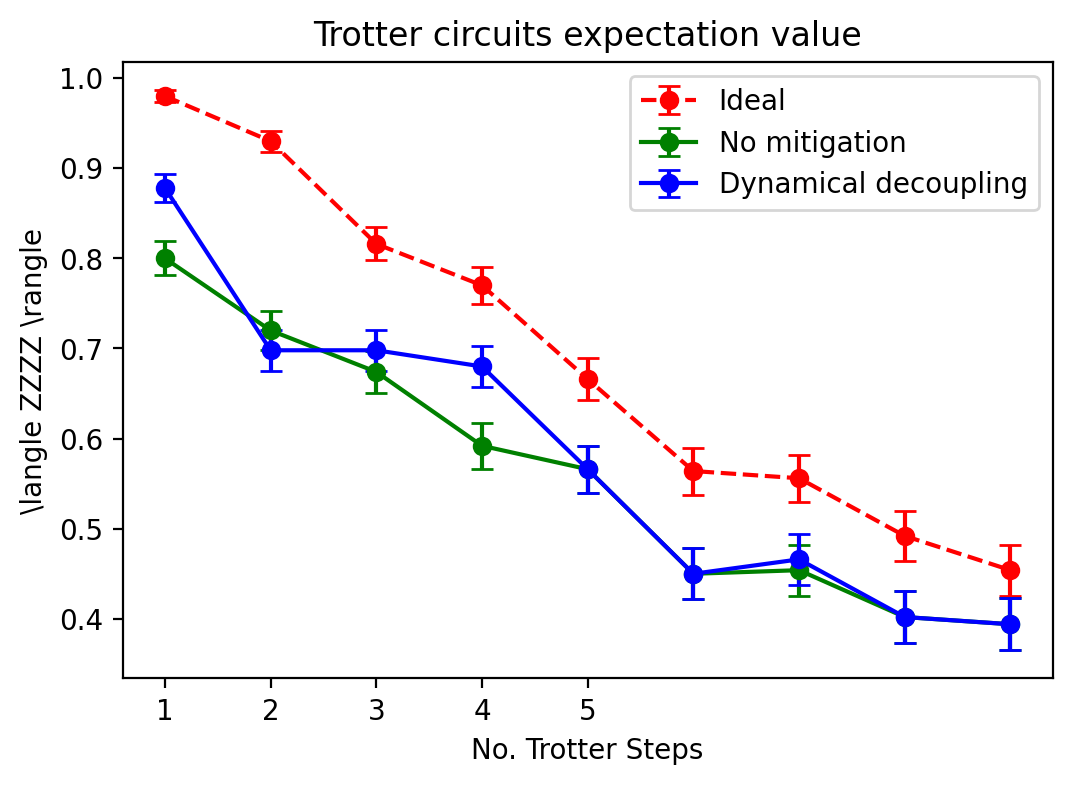

In [6]:


plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="o",
    linestyle="--",
    capsize=4,
    c="red",
    label="Ideal",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="green",
    label="No mitigation",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit_dd,
    std_error_dd,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="blue",
    label="Dynamical decoupling",
)

plt.ylabel(f"\langle ZZZZ \\rangle")
plt.xlabel("No. Trotter Steps")
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

## Error mitigation
Error mitigation introduces _quantum overhead_ to our calculations.

Typically, error correction uses the outputs of multiple ensembles of noisy calculations to reduce or eliminate the noise in estimating quantities like expectation values — commonly by using classical post-processing. In this regard, error mitigation is different from error correction. Rather than fixing errors in every circuit run, errors are allowed to occur, then better results are inferred from several of these noisy calculations. 

Since there is no threshold that one must surpass before quantum error mitigation becomes practical, we see error mitigation as the key to realizing useful quantum computers in the near term.

We are developing a portfolio of different error mitigation techniques, looking for three main things:

- Small overhead (_speed_)
- Improved accuracy (_quality_)
- Few assumptions (_scale_)

Each method come with their own associated overhead: a trade-off between the number of quantum computations needed (time) and the  accuracy of our results. The level of accuracy that can be achieved is also specific to each method, and is usually inversely proportional to the previously mentioned overhead. Defining $\lambda$ as the base noise in our computation:

| Methods           | T-REx | ZNE                        | PEC                         |
|-------------------|-------|----------------------------|-----------------------------|
| Assumptions       | None  | Ability to scale the noise | Full knowledge of the noise |
| Qubit overhead    | $1$   | $1$                        | $1$                         |
| Sampling overhead | $2$   | $N_\text{noise-factors}$   | $\mathcal{O}(e^{\lambda N_\text{layers}})$    |
| Bias              | $0$   | $\mathcal{O}(\lambda^{N_\text{noise-factors}})$ | $0$      |

More detailed information is available at:

- T-REx: [arXiv:2012.09738](https://arxiv.org/abs/2012.09738)
- ZNE: [arXiv:1612.02058](https://arxiv.org/abs/1612.02058)
- PEC: [arXiv:1612.02058](https://arxiv.org/abs/1612.02058) 

By having a portfolio of methods, users can choose which technique makes the most sense for their problem of interest, based on accuracy demands and how much overhead they are willing to accept. We are excited about this because, in the best scenarios, we can achieve unbiased results (that is, noise-free); and we want to make this capability accessible all across the stack: from kernel to algorithm and model developers.

### Why is error mitigation important?
We need improvements in _scale_, _quality_, and _speed_.

The promise of error mitigation is to translate the continuous progress in quantum hardware into continuous improvements in quantum computations and quantum information processing. We expect that, while insufficient to fully overcome imperfections, every advancement should incrementally push the frontier of what can be achieved practically; as opposed to a scenario where little to no progress is made until we suddenly overcome the fault-tolerant threshold.



Beyond the 100x100 circuit, we envision a future where error correction and error mitigation can work in a hybrid way. In that regard, this approach has proven to be both practically effective and intellectually challenging.

### Concepts

The following terms are used in this section.

<div class="alert alert-warning">
    <i class="fas fa-exclamation-triangle"></i>
    <b>TERMINOLOGY</b>
    
    As with every nascent field, terminology is sometimes incosistent: people use the same terms to refer to (slightly) different things.
</div>

<ul>
    <li> <b>Estimators</b>: Strategies for approximating certain physical values that are fundamentally unknown.
    <li> <b>Sampling</b>: The process of taking several measurements of one or several things.
    <li> <b>Overhead</b>: Extra costs introduced by new techniques, relative to a base implementation.
    <li> <b>Bias</b>: A systematic drift in the measured quantities, usually caused by errors.
    <li> <b>Shot/sample noise</b>: Uncertainty in the obtained results due to a lack of infinite precision (that is, a finite number of samples).
</ul>


### Implications
When implementing any error mitigation technique, we expect the _bias_ in our results to be reduced with respect to the previous, unmitigated, bias; in some cases even disappearing. However, this comes at a cost. As we reduce the bias in our estimated quantities, the statistical variability will increase (that is, _variance_),  which we can account for by further increasing the number of shots per circuit in our sampling process. This will introduce overhead beyond that needed to reduce the bias, therefore it is not done by default. The user can easily opt in to this behavior by adjusting the amount of `shots` per circuit in `run_options`.

In mathematical terms, we expect our error mitigated estimator to be such that:

$$
0 \leq
| \text{Bias}[{\langle}O{\rangle}_\text{em}] | \leq 
| \text{Bias}[{\langle}O{\rangle}_\text{noisy}] | \\
| \text{Var}[{\langle}O{\rangle}_\text{em}] | \geq 
| \text{Var}[{\langle}O{\rangle}_\text{noisy}] | > 0
$$

<div>
<img src="images/bias_variance_trade_off.png" width="700">
</div>

### Twirled readout error extinction
Twirled readout error extinction (T-REx) uses a technique known as Pauli twirling to reduce the noise introduced during the process of quantum measurement. This technique assumes no specific form of noise, which makes it very general and effective.

#### Overall workflow
1. Acquire data for the zero state with randomized bit flips (Pauli X before measurement)
2. Acquire data for the desired (noisy) state with randomized bit flips (Pauli X before measurement)
3. Compute the special function for each data set, and divide.



__Reference__: E. van den Berg, Z. Minev, and K. Temme, _Model-free readout-error mitigation for quantum expectation values_ [arXiv:2012.09738](https://arxiv.org/abs/2012.09738)

In [7]:
options = Options()
options.resilience_level = 1  # T-REx
options.optimization_level = 0  # No optimization
options.execution.shots = 1000

from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Make a noise model
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}


with Session(service=service, backend=backend_simulator) as session:
    estimator = Estimator(session=session, options=options)
    job_trex = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_trex.job_id)
    print(job_trex.result())

expvals_unmit_trex = job_trex.result().values
expvals_unmit_trex_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_trex.result().metadata
]
std_error_trex = np.sqrt(expvals_unmit_trex_variance)

job id: <bound method JobV1.job_id of <RuntimeJob('ckjl27kmjg3o140mid00', 'estimator')>>
EstimatorResult(values=array([0.93460317, 0.82520147, 0.74393162, 0.63452991, 0.59702076,
       0.52200244, 0.44698413, 0.46261294, 0.42822955]), metadata=[{'variance': 1.6083535924122006, 'shots': 1008, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 1.8008792282198876, 'shots': 1008, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 1.9284024253049894, 'shots': 1008, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 2.079208473957192, 'shots': 1008, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 2.1254029020768948, 'shots': 1008, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 2.20935013693402, 'shots': 1008,

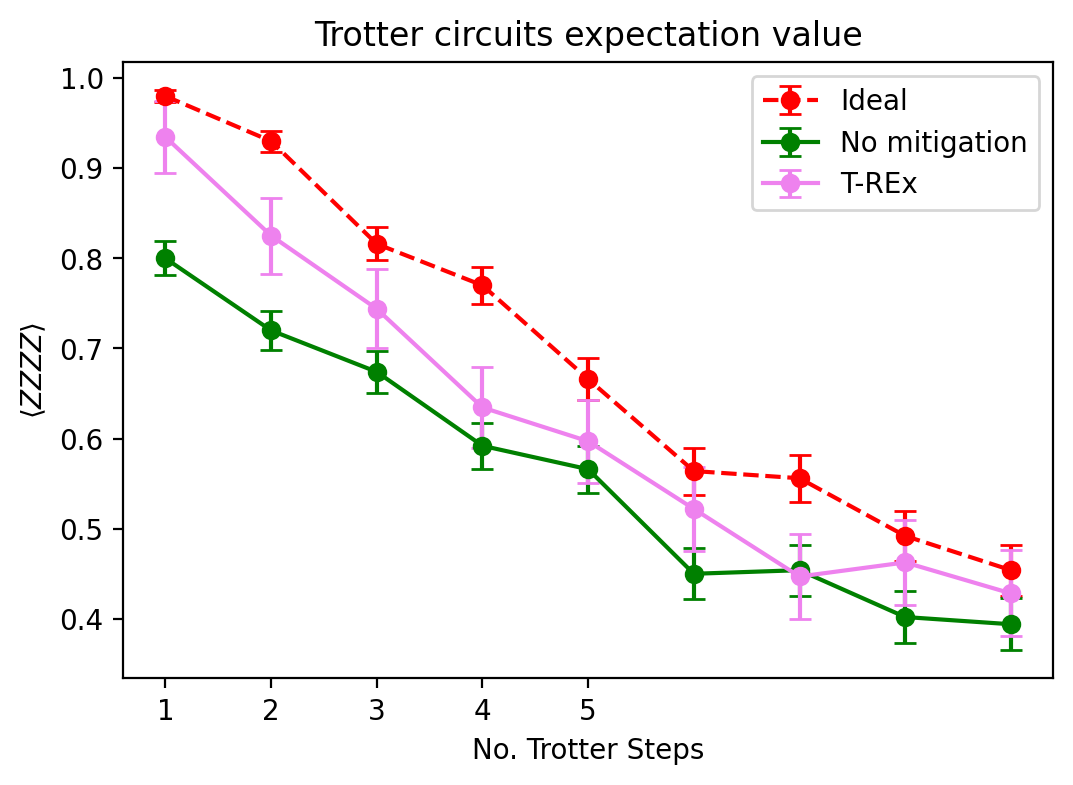

In [8]:
plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="o",
    linestyle="--",
    capsize=4,
    c="red",
    label="Ideal",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="green",
    label="No mitigation",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit_trex,
    std_error_trex,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="violet",
    label="T-REx",
)

plt.ylabel(f"$\langle ZZZZ \\rangle$")
plt.xlabel("No. Trotter Steps")
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

### Zero noise extrapolation
Zero noise extrapolation (ZNE) works by first amplifying the noise in the circuit that is preparing the desired quantum state, obtaining measurements for several different levels of noise, and using those measurements to infer the noiseless result. 

#### Overall workflow
1. Amplify circuit noise for several noise factors
2. Run every noise amplified circuit
3. Extrapolate back to the zero noise limit



In [9]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 2  # ZNE

from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Make a noise model
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}


with Session(service=service, backend=backend_simulator) as session:
    estimator = Estimator(session=session, options=options)
    job_zne = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_zne.job_id)
    print(job_zne.result())

expvals_unmit_zne = job_zne.result().values
# Standard error: coming soon!

job id: <bound method JobV1.job_id of <RuntimeJob('ckjl2a41recafbbdq4sg', 'estimator')>>
EstimatorResult(values=array([0.8065    , 0.7555    , 0.68      , 0.62383333, 0.51666667,
       0.458     , 0.35683333, 0.381     , 0.38966667]), metadata=[{'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 3, 5], 'values': [0.8, 0.782, 0.77], 'variance': [0.3599999999999999, 0.38847599999999993, 0.4071], 'shots': [1000, 1000, 1000]}, 'extrapolation': {'extrapolator': 'LinearExtrapolator'}}}, {'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 3, 5], 'values': [0.746, 0.762, 0.736], 'variance': [0.443484, 0.41935599999999995, 0.45830400000000004], 'shots': [1000, 1000, 1000]}, 'extrapolation': {'extrapolator': 'Line

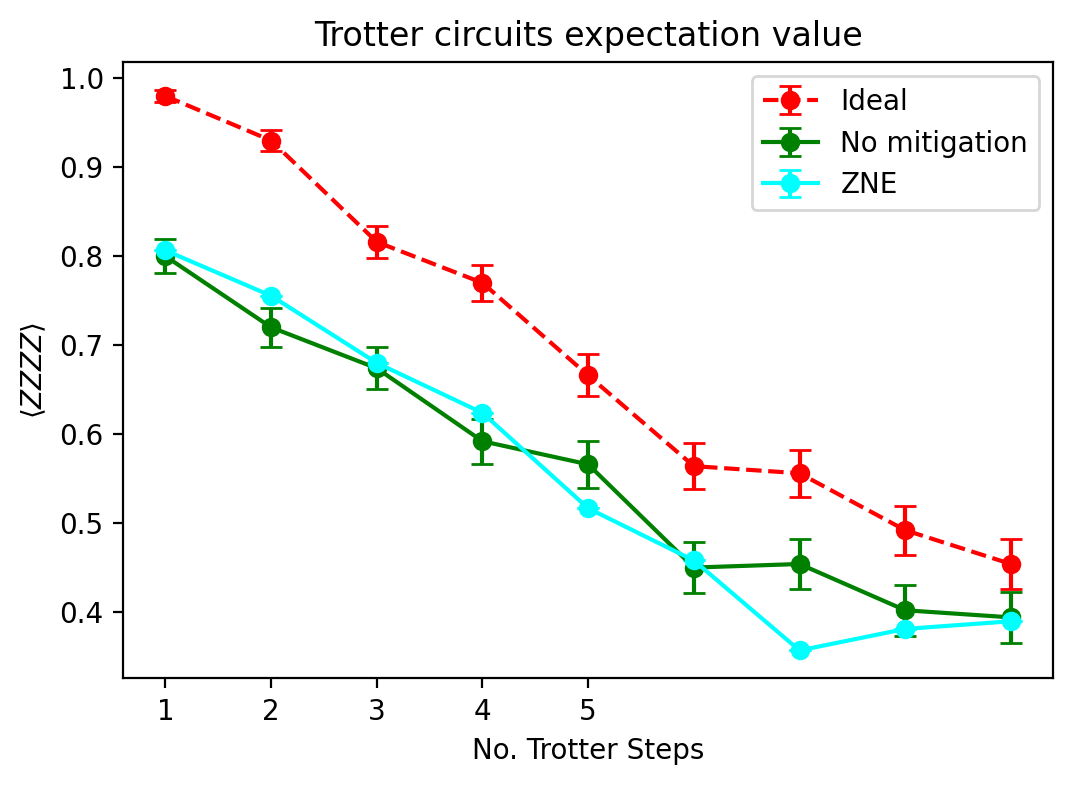

In [10]:
plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="o",
    linestyle="--",
    capsize=4,
    c="red",
    label="Ideal",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="green",
    label="No mitigation",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit_zne,
    [0] * (num_steps - 1),
    fmt="o",
    linestyle="-",
    capsize=4,
    c="cyan",
    label="ZNE",
)

plt.xlabel("No. Trotter Steps")
plt.ylabel(f"$\langle ZZZZ \\rangle$")
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

### Probabilistic error cancellation
Probabilistic error cancellation (PEC) samples for a collection of circuits that, on average mimics a noise inverting channel to cancel out the noise in the desired computation. This process is a bit like how noise-cancelling headphones work, and produces great results; however, it is not as general as other methods, and the sampling overhead is exponential.

__Reference__: E. van den Berg, Z. Minev, A. Kandala, and K. Temme, _Probabilistic error cancellation with sparse Pauli-Lindblad models on noisy quantum processors_ [arXiv:2201.09866](https://arxiv.org/abs/2201.09866)



In [11]:
def interim_results_callback(job_id, result):
    now = datetime.datetime.now()
    print(now, "*** Callback ***", result, "\n")


options = Options()
options.optimization_level = 0  # No optimization
options.execution.shots = 100
options.resilience_level = 3  # PEC
options.environment.callback = interim_results_callback


from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Make a noise model
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}


with Session(service=service, backend=backend_simulator) as session:
    estimator_pec = Estimator(session=session, options=options)
    job_pec = estimator_pec.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_pec.job_id)

expvals_pec = job_pec.result().values
std_error_pec = [metadata["standard_error"] for metadata in job_pec.result().metadata]

job id: <bound method JobV1.job_id of <RuntimeJob('ckjl2ccmjg3o140miiug', 'estimator')>>
2023-10-12 10:51:49.471956 *** Callback *** {'unique_layers_detected': 4, 'total_layers': 189} 

2023-10-12 10:53:06.906200 *** Callback *** {'msg': 'Sampling overhead for layer 1/4: 1.0743974577288362'} 

2023-10-12 10:55:47.858103 *** Callback *** {'msg': 'Sampling overhead for layer 3/4: 1.059164087161155'} 

2023-10-12 10:55:49.156186 *** Callback *** {'msg': 'Sampling overhead for layer 2/4: 1.2589524672739838'} 

2023-10-12 10:55:49.504184 *** Callback *** {'msg': 'Sampling overhead for layer 4/4: 1.1246591365360687'} 

2023-10-12 10:55:49.770372 *** Callback *** {'unique_mitigated_layers': 2, 'unique_mitigated_layers_sampling_overhead': [1.0743974577288362, 1.2589524672739838], 'total_sampling_overhead': 1.8295682316019255} 

2023-10-12 10:55:50.082490 *** Callback *** {'unique_mitigated_layers': 2, 'unique_mitigated_layers_sampling_overhead': [1.059164087161155, 1.1246591365360687], 'total_

In [12]:
obs_list

[SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZZZ'],
               coeffs=[1.+0.j])]

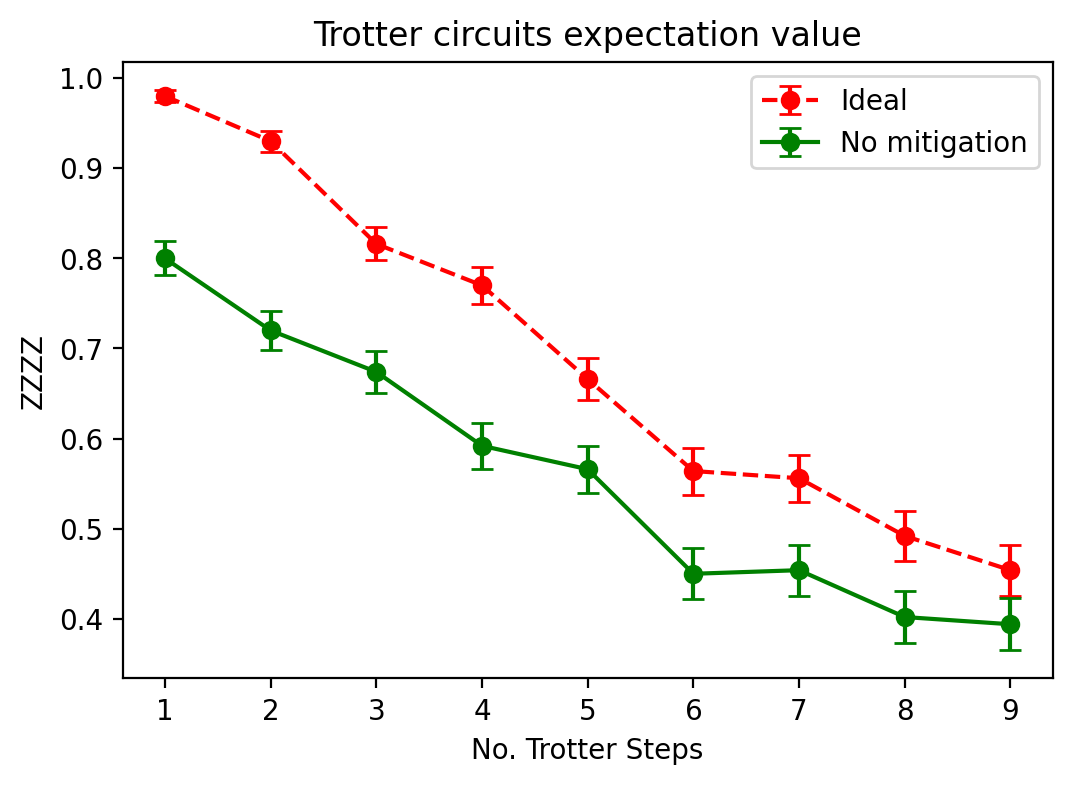

In [20]:
plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="o",
    linestyle="--",
    capsize=4,
    c="red",
    label="Ideal",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="green",
    label="No mitigation",
)
# plt.errorbar(
#     range(1, num_steps),
#     expvals_pec,
#     std_error_pec,
#     fmt="d",
#     linestyle="-",
#     capsize=4,
#     c="orange",
#     label="PEC",
# )

plt.ylabel(f"ZZZZ")
plt.xlabel("No. Trotter Steps")
# plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

## Advanced ZNE options


### Noise amplification
As a first approach, we provide a noise amplification technique known as _unitary folding_. 

__Reference__: Tudor Giurgica-Tiron, Yousef Hindy, Ryan LaRose, Andrea Mari, and William J. Zeng, _Digital zero noise extrapolation for quantum error mitigation_ [arXiv:2005.10921](https://arxiv.org/abs/2005.10921).





In [14]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # no optimization
options.resilience_level = 2  # ZNE
options.resilience.noise_factors = [1, 2, 3, 4]
options.resilience.noise_amplifier = "LocalFoldingAmplifier"
options.resilience.extrapolator = "QuadraticExtrapolator"

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    estimator = Estimator(session=session, options=options)
    job_zne_options = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_zne_options.job_id)
    print(job_zne_options.result())

job id: <bound method JobV1.job_id of <RuntimeJob('ckjl4dqeen13a87i3u50', 'estimator')>>
EstimatorResult(values=array([0.9605, 0.94  , 0.8295, 0.8235, 0.6925, 0.6035, 0.4335, 0.4775,
       0.4785]), metadata=[{'zne': {'noise_amplification': {'noise_amplifier': "<LocalFoldingAmplifier:{'gates_to_fold': None, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 2, 3, 4], 'values': [0.974, 0.984, 0.98, 0.976], 'variance': [0.051324000000000036, 0.031743999999999994, 0.03960000000000008, 0.04742400000000002], 'shots': [1000, 1000, 1000, 1000]}, 'extrapolation': {'extrapolator': 'QuadraticExtrapolator'}}}, {'zne': {'noise_amplification': {'noise_amplifier': "<LocalFoldingAmplifier:{'gates_to_fold': None, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 2, 3, 4], 'values': [0.924, 0.926, 0.91, 0.924], 'variance': [0.1462239999999999, 0.142523999999999

```json
{
  "values": [
    0.928499999999999,
    0.8165,
    0.835,
    0.6815000000000001,
    0.49449999999999983
  ],
  "metadata": [
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "<LocalFoldingAmplifier:{'gates_to_fold': None, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
          "noise_factors": [
            1,
            2,
            3,
            4
          ],
          "values": [
            0.838,
            0.798,
            0.738,
            0.752
          ],
          "variance": [
            0.297756,
            0.36319599999999996,
            0.455356,
            0.434496
          ],
          "shots": [
            1000,
            1000,
            1000,
            1000
          ]
        },
        "extrapolation": {
          "extrapolator": "QuadraticExtrapolator"
        }
      }
    },
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "<LocalFoldingAmplifier:{'gates_to_fold': None, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
          "noise_factors": [
            1,
            2,
            3,
            4
          ],
          "values": [
            0.732,
            0.676,
            0.572,
            0.522
          ],
          "variance": [
            0.46417600000000003,
            0.543024,
            0.6728160000000001,
            0.727516
          ],
          "shots": [
            1000,
            1000,
            1000,
            1000
          ]
        },
        "extrapolation": {
          "extrapolator": "QuadraticExtrapolator"
        }
      }
    },
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "<LocalFoldingAmplifier:{'gates_to_fold': None, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
          "noise_factors": [
            1,
            2,
            3,
            4
          ],
          "values": [
            0.674,
            0.51,
            0.436,
            0.328
          ],
          "variance": [
            0.5457239999999999,
            0.7399,
            0.809904,
            0.892416
          ],
          "shots": [
            1000,
            1000,
            1000,
            1000
          ]
        },
        "extrapolation": {
          "extrapolator": "QuadraticExtrapolator"
        }
      }
    },
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "<LocalFoldingAmplifier:{'gates_to_fold': None, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
          "noise_factors": [
            1,
            2,
            3,
            4
          ],
          "values": [
            0.512,
            0.372,
            0.266,
            0.188
          ],
          "variance": [
            0.7378560000000001,
            0.8616159999999999,
            0.929244,
            0.964656
          ],
          "shots": [
            1000,
            1000,
            1000,
            1000
          ]
        },
        "extrapolation": {
          "extrapolator": "QuadraticExtrapolator"
        }
      }
    },
    {
      "zne": {
        "noise_amplification": {
          "noise_amplifier": "<LocalFoldingAmplifier:{'gates_to_fold': None, 'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
          "noise_factors": [
            1,
            2,
            3,
            4
          ],
          "values": [
            0.442,
            0.35,
            0.268,
            0.13
          ],
          "variance": [
            0.804636,
            0.8775000000000001,
            0.928176,
            0.9831
          ],
          "shots": [
            1000,
            1000,
            1000,
            1000
          ]
        },
        "extrapolation": {
          "extrapolator": "QuadraticExtrapolator"
        }
      }
    }
  ]
}
```

In [15]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.12.2'

In [16]:
from qiskit.tools import jupyter

%qiskit_version_table
%qiskit_copyright